<a href="https://colab.research.google.com/github/youkjang/Machine-Learning-Deep-Learning-Practice/blob/main/ENSO_composite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ENSO composites

### Data
* https://psl.noaa.gov/data/gridded/tables/monthly.html
* PDSI (Palmer Drought Severity Index) 
* Precipitation
* Soil moisture
* SST (sea surface temperature)


### Reference
- https://github.com/rabernat/research_computing/blob/master/content/lectures/python/xarray.ipynb

- https://github.com/afahadabdullah/pythonforclimateintro/blob/master/Python_climate.ipynb

In [1]:
pip install netCDF4

     |████████████████████████████████| 4.7MB 8.3MB/s 
     |████████████████████████████████| 296kB 49.5MB/s 


In [2]:
import numpy as np
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt

### Load SST, PDSI, Precipitation, Soil moisture data 

In [3]:
ds_sst = xr.open_dataset('sst.mnmean.v3.nc')

In [4]:
df_pdsi = xr.open_dataset('pdsi.mon.mean.selfcalibrated.nc')

In [5]:
df_precip = xr.open_dataset('precip.mon.mean.nc')

In [6]:
df_soilw = xr.open_dataset('soilw.mon.mean.v2.nc')

In [7]:
sst = ds_sst.sst
sst

<xarray.DataArray 'sst' (time: 1994, lat: 89, lon: 180)>
[31943880 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-02-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    precision:     2
    var_desc:      Sea Surface Temperature
    dataset:       NOAA Extended Reconstructed SST V3b
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    actual_range:  [-1.8  33.95]
    valid_range:   [-5. 40.]

In [8]:
precip = df_precip.precip
pdsi = df_pdsi.pdsi
soilw = df_soilw.soilw

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


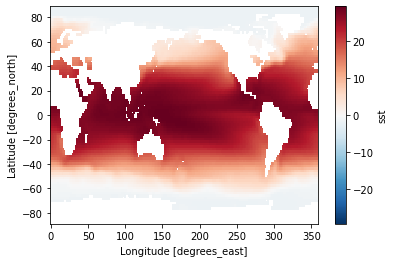

In [9]:
sst.mean(dim='time').plot()

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


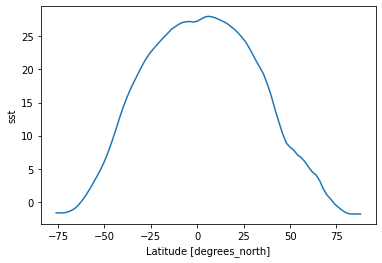

In [10]:
sst.mean(dim=('time', 'lon')).plot()

### Climatology & Anomalies
- Monthly mean is calcuated for climatology and climatology is removed for anomalies.

In [11]:
def mk_anom(input):
  clim = input.groupby('time.month').mean(dim='time')
  anom = input.groupby('time.month') - clim
  return anom

In [12]:
sst_anom = mk_anom(sst)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


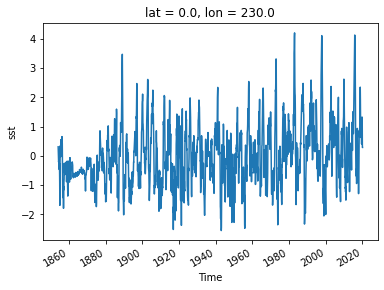

In [13]:
sst_anom.sel(lon=230, lat=0, method='nearest').plot()

In [14]:
precip_anom = mk_anom(precip)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [15]:
pdsi_anom = mk_anom(pdsi)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [16]:
soilw_anom = mk_anom(soilw)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


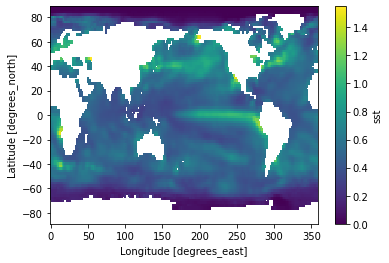

In [17]:
sst_anom.std(dim='time').plot()

## NINO3.4 Index
El Niño (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This standard of measure is known as the Oceanic Niño Index (ONI).
https://github.com/rabernat/research_computing/blob/master/content/lectures/python/xarray.ipynb

In [18]:
sst_anom_nino34 = sst_anom.sel(lat=slice(5, -5), lon=slice(190, 240))

In [19]:
sst_anom_nino34_mean = sst_anom_nino34.mean(dim=('lon', 'lat'))
oni = sst_anom_nino34_mean.rolling(time=3).mean(dim='time')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Reductions will be applied along the rolling dimension 'time'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  


In [20]:
sst_anom_nino34_mean

<xarray.DataArray 'sst' (time: 1994)>
array([ 0.13549341,  0.00133032, -0.14601709, ...,  1.1011418 ,
        0.7420319 ,  0.7224842 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-02-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 4 5 6 7 8 9 10 11 12 1 2

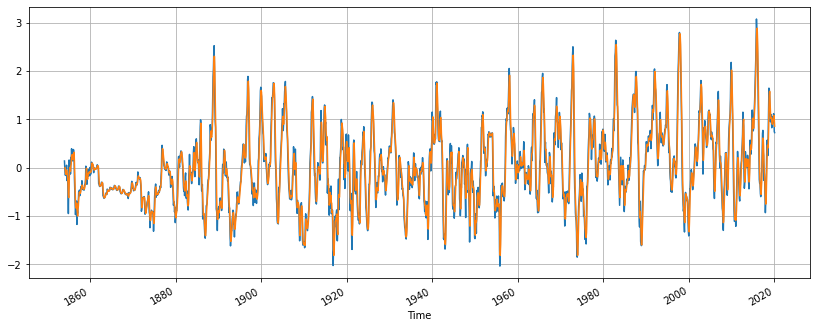

In [21]:
fig, ax = plt.subplots(figsize = (14,5))
sst_anom_nino34_mean.plot(ax=ax, label='raw')
oni.plot(ax=ax, label='smoothed')
ax.grid()

### Create a categorical  data array: NINO and NINA

In [22]:
nino34 = xr.full_like(oni, 'none', dtype='U4')
nino34[oni >= 0.5] = 'nino'
nino34[oni <= -0.5] = 'nina'
nino34

<xarray.DataArray (time: 1994)>
array(['none', 'none', 'none', ..., 'nino', 'nino', 'nino'], dtype='<U4')
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-02-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 4 5 6 7 8 9 10 11 12 1 2

### Composites of SST with ONI
- SST: 1854 ~ 2020

In [23]:
sst_nino_composite = sst_anom.groupby(nino34.rename('nino34')).mean(dim='time')

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


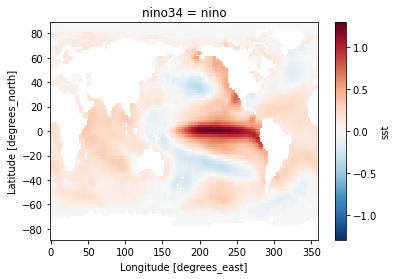

In [24]:
sst_nino_composite.sel(nino34='nino').plot()

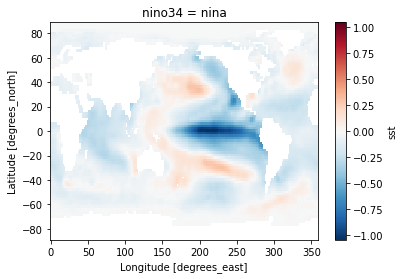

In [25]:
sst_nino_composite.sel(nino34='nina').plot()

### Composites of Precipitation with ONI
- Precipitation data: 1979 ~ 2019

In [26]:
precip79  = precip_anom.sel(time=slice('1979','2019'))
nino34_79 = nino34.sel(time=slice('1979-01-01','2019-12-01'))

In [27]:
precip_composite = precip79.groupby(nino34_79.rename('nino34_79')).mean(dim='time')

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


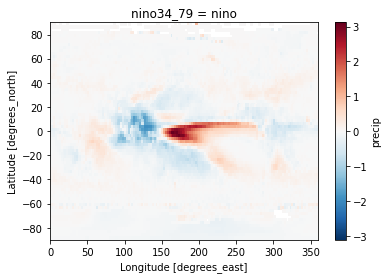

In [28]:
precip_composite.sel(nino34_79 = 'nino').plot()

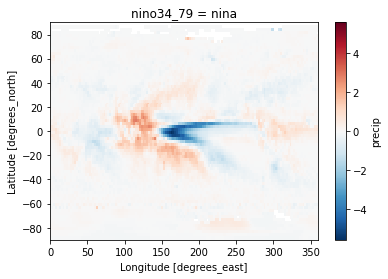

In [29]:
precip_composite.sel(nino34_79 = 'nina').plot()

### Composites of PDSI with ONI
- PDSI data: 1854 ~ 2014

In [30]:
pdsi1854 = pdsi_anom.sel(time=slice('1854','2014'))
nino34_1854 = nino34.sel(time=slice('1854-01-01','2014-12-01'))

In [31]:
pdsi_composite = pdsi1854.groupby(nino34_1854.rename('nino34_1854')).mean(dim='time')

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


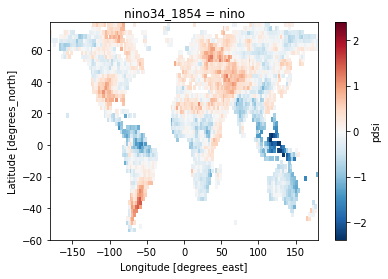

In [32]:
pdsi_composite.sel(nino34_1854 ='nino').plot()

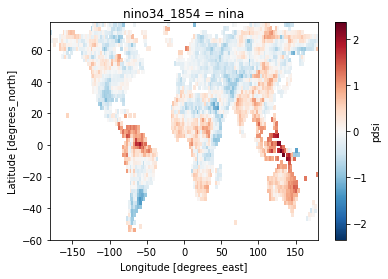

In [33]:
pdsi_composite.sel(nino34_1854 ='nina').plot()

### Composites of Soilw with ONI
- Soilw data: 1948 ~ 2019

In [34]:
soilw48 = soilw_anom.sel(time=slice('1948','2019'))
nino34_48 = nino34.sel(time=slice('1948-01-01','2019-12-01'))

In [35]:
soilw_composite = soilw48.groupby(nino34_48.rename('nino34_48')).mean(dim='time')

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


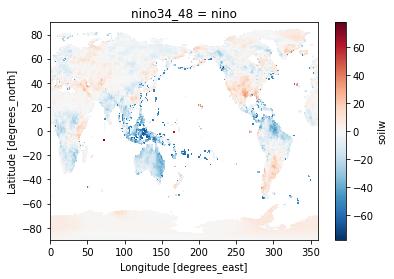

In [36]:
soilw_composite.sel(nino34_48 = 'nino').plot()

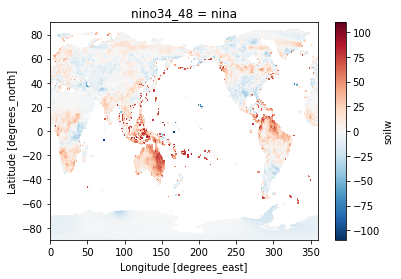

In [37]:
soilw_composite.sel(nino34_48 = 'nina').plot()